In [15]:
"""
情感预测的练习。对于这个练习，
对于精度有影响的：
    1.增加训练集。5000->10000，精度提升10%。
    2.增加模型复杂度。simple->LSTM，更重要的是simple容易过拟合。
    3.stopword在此问题中不应该去除，会降低精度。主要原因应该是shouldn't之类可以判断情感的词被过滤掉了。
    4.增加epoch的次数。
减小过拟合的方法：
    1.加入dropout。
    2.降低模型复杂度。LSTM单元数减少。
"""

import pandas as pd
from numpy import zeros
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords 
from sklearn.model_selection import train_test_split
import gensim
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Activation, Dropout, Dense, LSTM, Bidirectional
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras import regularizers
import nltk
nltk.download('punkt')
nltk.download('stopwords')

TAG_RE = re.compile(r'<[^>]+>')
max_row = 10000

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type, file_name):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.savefig(file_name)


def correct_and_wrong():
    # fit_on_texts错误的用法
    tokenizer2 = Tokenizer(num_words=5000)
    tokenizer2.fit_on_texts([["I am god"], ["you are idiot"]])
    print(tokenizer2.word_index)
    # fit_on_texts正确的用法
    tokenizer3 = Tokenizer(num_words=5000)
    tokenizer3.fit_on_texts([["I", "am", "god"], ["you", "are", "idiot"]])
    print(tokenizer3.word_index)
    # gensim.models.Word2Vec的错误用法
    word_model2 = gensim.models.Word2Vec([["I am god"], ["you are idiot"]], min_count=1, size=5, window=5)
    word_model2.wv.save_word2vec_format("wrong_embedding")
    # gensim.models.Word2Vec的正确用法
    word_model3 = gensim.models.Word2Vec([["I", "am", "god"], ["you", "are", "idiot"]], min_count=1, size=5, window=5)
    word_model3.wv.save_word2vec_format("correct_embedding")


def column_text_to_sentence_array(lines, use_stop_word=False):
    stopwords_en = set()
    if use_stop_word:
        stopwords_en = set(stopwords.words('english'))
    sentence_array = []
    word_num = 0
    word_set = set()
    for line in lines:
        temp = []
        for word in word_tokenize(line):
            if word not in stopwords_en:
                word_num += 1
                word_uniform = word.lower()
                word_set.add(word_uniform)
                temp.append(word_uniform)
        sentence_array.append(temp)
    uniq_word_num = len(word_set)
    return sentence_array, word_num, word_set


def remove_tags(text):
    return TAG_RE.sub('', text)


def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence


def predict_single(review, model):
    review = tokenizer.texts_to_sequences(review)
    flat_list = []
    for sublist in review:
        for item in sublist:
            flat_list.append(item)
    flat_list = [flat_list]
    review = pad_sequences(flat_list, padding='post', maxlen=maxlen)
    print(model.predict(review))


def build_int_to_vector_mapping(tokenizer, word_vector):
    """
    现在有两个映射
    1. gensim 的 word->vector 存在word_vector
    2. tokenizer 的 word->int 存在tokenizer
    矩阵中存放 int->vector的映射
    最终的映射是 ["I" "am" "a" "super" "star"] -> [1, 3, 4, 5, 7] -> [[0.1, 0.4], [0.21, 0.233] ...]
    在Embedding layer embedding matrix被传入
    """
    embedding_matrix = zeros((vocab_size, 100))
    for word, index in tokenizer.word_index.items():
        try:
            embedding_vector = word_vector[word]
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector
        except KeyError:
            print("word {} is OOV".format(word))
            pass
    return embedding_matrix


# 1. 读取数据
movie_reviews = pd.read_csv("./input_data/IMDB_Dataset.csv")
movie_reviews.info()
movie_reviews = movie_reviews[0:max_row]
# 2. 预处理数据
movie_reviews["review"] = movie_reviews["review"].map(lambda x: preprocess_text(x))
movie_reviews["sentiment"] = movie_reviews["sentiment"].map(lambda x: 1 if x=="positive" else 0)
movie_reviews.head()
X = movie_reviews["review"]
Y = movie_reviews["sentiment"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

# 3. 使用gensim训练词向量
data, word_num, word_set = column_text_to_sentence_array(movie_reviews["review"], True)
# cannot -> can, not
# data[13]
print("total word number : {}".format(word_num))
print("total uniq word : {}".format(len(word_set)))
model_COBW = gensim.models.Word2Vec(data, min_count=1, size=100, window=5)
word_vector = model_COBW.wv
# like word -> vector dict
print("word to vecotr number : {}".format(len(word_vector.index2word)))

# 4. 将word数组转换为int数组，只保存5000个频率最高的映射？
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data)
"""
correct_and_wrong()
tokenizer.fit_on_texts(X_train) 这里不能这么写，要用data来fit_on_texts。
原因是nltk.tokenize的word_tokenize和keras.preprocessing.fit_on_texts对于有些词不一样，例如cannot, nltk处理成了can和not，但是
fit_on_text的时候将 cannot当成一个词了
"""
print("word to int number : {}".format(len(tokenizer.word_index)))
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
vocab_size = len(tokenizer.word_index) + 1



[nltk_data] Downloading package punkt to /Users/ray/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/ray/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
review       50000 non-null object
sentiment    50000 non-null object
dtypes: object(2)
memory usage: 781.4+ KB
total word number : 1260284
total uniq word : 52191
word to vecotr number : 52191
word to int number : 52191


In [16]:
# 5. 填充成一样的长度
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

# 6. 获取输入层的weights
embedding_mapping = build_int_to_vector_mapping(tokenizer, word_vector)

# 6. 训练和测试
sample_review = X[57]
# print(sample_review)

In [17]:
def current_time():
    now = datetime.now()
    dt_string = now.strftime("%Y_%m_%d_%H_%M_%S")
    return dt_string

def epoch_performance(history, model_name):
    print("model name : {}".format(model_name))
    for i in history.epoch:
        print("epoch {}".format(i))
        print("train acc : {} validate acc : {}".format(history.history["acc"][i], history.history["val_acc"][i]))
        print("train loss : {} validate loss : {}".format(history.history["loss"][i], history.history["val_loss"][i]))

In [18]:
def simple_model(model_name, dict_size, embedding_matrix, maxlen, X_train, X_test, Y_train, Y_test):
    model = Sequential()
    """
    All that the Embedding layer does is to map the integer inputs to the vectors found at the
    corresponding index in the embedding matrix,
    i.e. the sequence [1, 2] would be converted to [embeddings[1], embeddings[2]]
    这种模型overfitting比较严重。
    """
    model_info_file_prefix = "./model_info/{}_{}_".format(model_name, current_time())
    model_structure_file = model_info_file_prefix + "model_structure.png"
    embedding_layer = Embedding(dict_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
    model.add(embedding_layer)
    model.add(Flatten())
    # 光通过这个解决不了overfitting的问题
    # model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    plot_model(model, to_file=model_structure_file , show_shapes=True)
    if isinstance(Y, pd.core.series.Series):
        Y_train = Y_train.to_numpy()
    if isinstance(Y_test, pd.core.series.Series):
        Y_test = Y_test.to_numpy()
    history_plot = LossHistory()
    history = model.fit(X_train, Y_train, batch_size=64, epochs=20, verbose=1, validation_split=0.2, callbacks=[history_plot])
    epoch_performance(history, model_name)
    history_plot.loss_plot('epoch', model_info_file_prefix+"epoch.png")
    score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print("Test Score:", score)
    print("Test Accuracy:", accuracy)
    return model

start training simple model
Train on 6400 samples, validate on 1600 samples
Epoch 1/20
6400/6400 [==============================] - 3s 406us/sample - loss: 0.7125 - acc: 0.5967 - val_loss: 0.6016 - val_acc: 0.6769
Epoch 2/20
6400/6400 [==============================] - 1s 138us/sample - loss: 0.5464 - acc: 0.7273 - val_loss: 0.6675 - val_acc: 0.6600
Epoch 3/20
6400/6400 [==============================] - 1s 139us/sample - loss: 0.4960 - acc: 0.7534 - val_loss: 0.5944 - val_acc: 0.6837
Epoch 4/20
6400/6400 [==============================] - 1s 138us/sample - loss: 0.4501 - acc: 0.7848 - val_loss: 0.5957 - val_acc: 0.6944
Epoch 5/20
6400/6400 [==============================] - 1s 141us/sample - loss: 0.4264 - acc: 0.8008 - val_loss: 0.5987 - val_acc: 0.7044
Epoch 6/20
6400/6400 [==============================] - 1s 138us/sample - loss: 0.4040 - acc: 0.8195 - val_loss: 0.6013 - val_acc: 0.7025
Epoch 7/20
6400/6400 [==============================] - 1s 137us/sample - loss: 0.3958 - acc: 0.

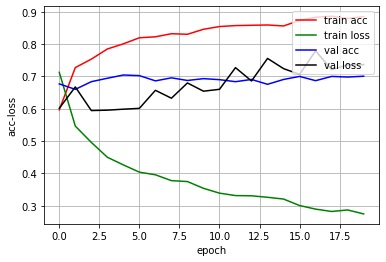

In [19]:
print("start training simple model")
model1 = simple_model("simple_model" ,vocab_size, embedding_mapping, maxlen, X_train, X_test, Y_train, Y_test)

In [20]:
def LSTM_many_to_one_model(model_name, dict_size, embedding_matrix, maxlen, X_train, X_test, Y_train, Y_test):
    model_info_file_prefix = "./model_info/{}_{}_".format(model_name, current_time())
    model_structure_file = model_info_file_prefix + "model_structure.png"
    model = Sequential()
    embedding_layer = Embedding(dict_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
    model.add(embedding_layer)
    model.add(LSTM(64))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    plot_model(model, to_file=model_structure_file, show_shapes=True)
    if isinstance(Y, pd.core.series.Series):
        Y_train = Y_train.to_numpy()
    if isinstance(Y_test, pd.core.series.Series):
        Y_test = Y_test.to_numpy()
    history_plot = LossHistory()
    history = model.fit(X_train, Y_train, batch_size=64, epochs=20, verbose=1, validation_split=0.2, callbacks=[history_plot])
    history_plot.loss_plot('epoch', model_info_file_prefix+"epoch.png")
    epoch_performance(history, model_name)
    score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print("Test Score:", score)
    print("Test Accuracy:", accuracy)
    return model

def LSTM_many_to_one_model_v2(model_name, dict_size, embedding_matrix, maxlen, X_train, X_test, Y_train, Y_test):
    """
    降低模型的overfit。
    """
    model_info_file_prefix = "./model_info/{}_{}_".format(model_name, current_time())
    model_structure_file = model_info_file_prefix + "model_structure.png"
    model = Sequential()
    embedding_layer = Embedding(dict_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
    model.add(embedding_layer)
    # 减少LSTM的个数
    model.add(LSTM(32))
    # 加入dropout
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    plot_model(model, to_file=model_structure_file, show_shapes=True)
    if isinstance(Y, pd.core.series.Series):
        Y_train = Y_train.to_numpy()
    if isinstance(Y_test, pd.core.series.Series):
        Y_test = Y_test.to_numpy()
    history_plot = LossHistory()
    history = model.fit(X_train, Y_train, batch_size=64, epochs=20, verbose=1, validation_split=0.2, callbacks=[history_plot])
    history_plot.loss_plot('epoch', model_info_file_prefix+"epoch.png")
    epoch_performance(history, model_name)
    score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print("Test Score:", score)
    print("Test Accuracy:", accuracy)
    return model

start training LSTM model
Train on 6400 samples, validate on 1600 samples
Epoch 1/20
6400/6400 [==============================] - 40s 6ms/sample - loss: 0.6433 - acc: 0.6269 - val_loss: 0.5649 - val_acc: 0.7144
Epoch 2/20
6400/6400 [==============================] - 37s 6ms/sample - loss: 0.5479 - acc: 0.7270 - val_loss: 0.5096 - val_acc: 0.7581
Epoch 3/20
6400/6400 [==============================] - 36s 6ms/sample - loss: 0.5126 - acc: 0.7542 - val_loss: 0.4958 - val_acc: 0.7769
Epoch 4/20
6400/6400 [==============================] - 36s 6ms/sample - loss: 0.5056 - acc: 0.7519 - val_loss: 0.4830 - val_acc: 0.7606
Epoch 5/20
6400/6400 [==============================] - 37s 6ms/sample - loss: 0.4700 - acc: 0.7806 - val_loss: 0.4668 - val_acc: 0.7894
Epoch 6/20
6400/6400 [==============================] - 37s 6ms/sample - loss: 0.4597 - acc: 0.7825 - val_loss: 0.4484 - val_acc: 0.7975
Epoch 7/20
6400/6400 [==============================] - 36s 6ms/sample - loss: 0.4431 - acc: 0.7911 - va

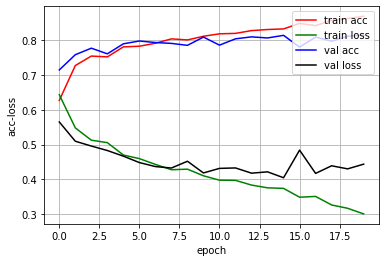

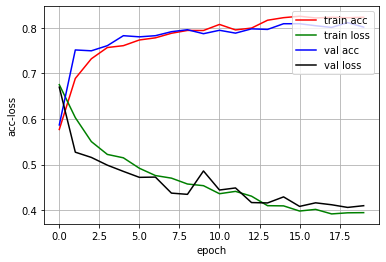

In [21]:
print("start training LSTM v1 model")
model3 = LSTM_many_to_one_model("LSTM_v1", vocab_size, embedding_mapping, maxlen, X_train, X_test, Y_train, Y_test)

print("start training LSTM v2 model")
model4 = LSTM_many_to_one_model_v2("LSTM_v2", vocab_size, embedding_mapping, maxlen, X_train, X_test, Y_train, Y_test)

In [22]:
def BI_LSTM_many_to_one_model(model_name, dict_size, embedding_matrix, maxlen, X_train, X_test, Y_train, Y_test):
    """
    降低模型的overfit。
    """
    model_info_file_prefix = "./model_info/{}_{}_".format(model_name, current_time())
    model_structure_file = model_info_file_prefix + "model_structure.png"
    model = Sequential()
    embedding_layer = Embedding(dict_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(32)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    plot_model(model, to_file=model_structure_file, show_shapes=True)
    if isinstance(Y, pd.core.series.Series):
        Y_train = Y_train.to_numpy()
    if isinstance(Y_test, pd.core.series.Series):
        Y_test = Y_test.to_numpy()
    history_plot = LossHistory()
    history = model.fit(X_train, Y_train, batch_size=64, epochs=20, verbose=1, validation_split=0.2, callbacks=[history_plot])
    history_plot.loss_plot('epoch', model_info_file_prefix+"epoch.png")
    epoch_performance(history, model_name)
    score, accuracy = model.evaluate(X_test, Y_test, verbose=0)
    print("Test Score:", score)
    print("Test Accuracy:", accuracy)
    return model

start training BI_LSTM model
Train on 6400 samples, validate on 1600 samples
Epoch 1/20
6400/6400 [==============================] - 50s 8ms/sample - loss: 0.6617 - acc: 0.5886 - val_loss: 0.5947 - val_acc: 0.6894
Epoch 2/20
6400/6400 [==============================] - 47s 7ms/sample - loss: 0.5610 - acc: 0.7100 - val_loss: 0.5150 - val_acc: 0.7456
Epoch 3/20
6400/6400 [==============================] - 44s 7ms/sample - loss: 0.5108 - acc: 0.7495 - val_loss: 0.4873 - val_acc: 0.7769
Epoch 4/20
6400/6400 [==============================] - 50s 8ms/sample - loss: 0.4971 - acc: 0.7530 - val_loss: 0.5003 - val_acc: 0.7563
Epoch 5/20
6400/6400 [==============================] - 55s 9ms/sample - loss: 0.4713 - acc: 0.7723 - val_loss: 0.4790 - val_acc: 0.7600
Epoch 6/20
6400/6400 [==============================] - 50s 8ms/sample - loss: 0.4525 - acc: 0.7898 - val_loss: 0.4735 - val_acc: 0.7675
Epoch 7/20
6400/6400 [==============================] - 58s 9ms/sample - loss: 0.4516 - acc: 0.7823 -

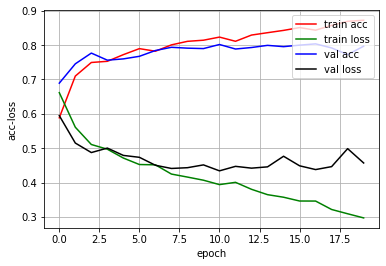

In [23]:
print("start training BI_LSTM model")
model5 = BI_LSTM_many_to_one_model("BI_LSTM_v1", vocab_size, embedding_mapping, maxlen, X_train, X_test, Y_train, Y_test)